In [3]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering as clustering
from sklearn.metrics import silhouette_score
from statsmodels.stats.oneway import effectsize_oneway as cohen
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 15


base_filepath = "/Users/44749/Documents/PhD_work/datasets_for_analysis/single_cell/"
save_filepath = "/Users/44749/Documents/PhD_work/datasets_for_analysis/figs_0512/"

In [4]:
#first load in data for a particular experiment
def load_data(exp_no, herit, no_cells_to_take, sel_level, mut=0.4, prefix="30Jul"):
    filename = prefix+"_"+str(herit)+"_"+str(mut)+"/"+sel_level+"_"+str(exp_no)
    #print(filename)
    sampled_types, sampled_alts, unique_types, abs_dist, frac_dist = np.load(base_filepath+filename+"_sampled_types_"+str(no_cells_to_take)+".npy", allow_pickle=True), np.load(base_filepath+filename+"_sampled_alts_"+str(no_cells_to_take)+".npy", allow_pickle=True), np.load(base_filepath+filename+"_unique_types_"+str(no_cells_to_take)+".npy", allow_pickle=True), np.load(base_filepath+filename+"_abs_dist_"+str(no_cells_to_take)+".npy", allow_pickle=True), np.load(base_filepath+filename+"_frac_dist_"+str(no_cells_to_take)+".npy", allow_pickle=True)
    #print(len(sampled_types), len(unique_types), len(np.unique(sampled_types)), len(np.unique(unique_types)), np.setdiff1d(sampled_types, unique_types))
    #print(sampled_types.dtype, unique_types.dtype)
    #except:
        #raise Exception("File not found")
    return sampled_types, sampled_alts, unique_types, abs_dist, frac_dist

#we have a dictionary of the distances between types; now make this into a dictionary of distances between cells
#this accepts either a fractional or an absolute matrix
def create_cell_distance_matrix(sampled_types, unique_types, type_dist_mat):
    type_to_index_dict = {}
    for n, type in enumerate(unique_types):
        type_to_index_dict[type] = n #record position in list
    cell_distance_mat = np.zeros((len(sampled_types), len(sampled_types)))
    for n, type in enumerate(sampled_types):
        #assert(type in unique_types)
        m = type_to_index_dict[type]
        for n_, type_ in enumerate(sampled_types):
            #assert(type_ in unique_types)
            m_ = type_to_index_dict[type_]
            cell_distance_mat[n][n_] = type_dist_mat[m][m_]
    return cell_distance_mat

#now cluster based on distance labels into k clusters, returns a list of labels
def make_k_clusters_and_get_score(cell_distance_matrix, k):
    clustered = clustering(n_clusters=k, metric='precomputed', linkage='complete')
    labels = clustered.fit_predict(cell_distance_matrix) 
    score = silhouette_score(cell_distance_matrix, labels, metric='precomputed')
    return labels, score

#sort cells into clones using silhouette clustering
def find_clones(sampled_types, unique_types, type_dist_mat, max_clones=10):
    cell_distance_mat = create_cell_distance_matrix(sampled_types, unique_types, type_dist_mat)
    label_sets, scores = [], []
    for k in range(2, max_clones+1):
        labels, score = make_k_clusters_and_get_score(cell_distance_mat, k)
        label_sets.append(labels)
        scores.append(score)
    best_index = np.argmin(np.array(scores))
    #print("scores", scores)
    #print("best index", best_index)
    best_k = best_index + 2 #the number of clones found- we impose at least 2
    return label_sets[best_index], best_k

#calculate the effect sizes
def calculate_cohens_f(labels, sampled_alts, k):
    means, variances, nums = np.zeros(k), np.zeros(k), np.zeros(k)
    for k_ in range(k):
        cells_in_clone = np.where(labels==k_)[0]
        fitness_incs = sampled_alts[cells_in_clone]
        means[k_], variances[k_], nums[k_] = np.average(fitness_incs), np.var(fitness_incs), len(cells_in_clone)
    if np.max(means) > 0: #there are cases where all cells have 0 fitness; if so then the effect size is 0
        use_var = 'unequal' if np.min(variances) > 0 else 'equal'  #IF ANY OF THE VARIANCES ARE ZERO, COHEN'S F WILL BREAK; SO WE CAN ONLY USE VARIANCES IF THEY'RE ALL NONZERO. IF NOT, WE HAVE TO ASSUME EQUAL WEIGHTING AND THUS EQUAL VARIANCE
        cohens_f = np.sqrt(cohen(means, variances, nums, use_var=use_var))
        if np.isnan(cohens_f):
            print("means", means)
            print("variances", variances)
            assert(1==0)
    else:
        cohens_f = 0
    return cohens_f

#get cohens f for a particular experiment- if this fails it will raise exception
def get_effect_size(exp_no, herit, no_cells_to_take, sel_level, mut=0.4, prefix="30Jul", distance_metric='fractional', max_clones=10):
    sampled_types, sampled_alts, unique_types, abs_dist, frac_dist = load_data(exp_no, herit, no_cells_to_take, sel_level, mut=mut, prefix=prefix)
    # for type in sampled_types:
    #     #print(exp_no, type)
    #     assert(type in unique_types)
        
    if distance_metric == "absolute":
        type_dist_mat = abs_dist
    else:
        if distance_metric == "fractional":
            type_dist_mat = frac_dist
        else:
            raise("Invalid distance metric")
    labels, k = find_clones(sampled_types, unique_types, type_dist_mat, max_clones=max_clones)
    cohens_f = calculate_cohens_f(labels, sampled_alts, k)
    return cohens_f, k

#for a particular herit level, get a set of cohens fs
def get_sizes(herit, no_cells_to_take, sel_level, num_exps=200,  mut=0.4, prefix="30Jul", distance_metric='absolute', max_clones=10):
    effect_sizes, num_clones = [], []
    print(herit, no_cells_to_take, sel_level)
    for exp_no in range(6, num_exps+6):
        #try:
        cohens_f, k = get_effect_size(exp_no, herit, no_cells_to_take, sel_level, mut=mut, prefix=prefix, distance_metric=distance_metric, max_clones=max_clones)
        #print("cohens f", cohens_f)
        effect_sizes.append(cohens_f)
        num_clones.append(k)
        #except:
            #print(exp_no, herit, no_cells_to_take, sel_level, mut, prefix, "error")
    return effect_sizes, num_clones


            
            


In [11]:
herits = [1.0]

for h in herits:
    for no_cells_to_take in [100, 200, 500, 1000]:
        for sel_level in ["lowsel", "highsel"]:
            effect_sizes, num_clones = get_sizes(h, no_cells_to_take, sel_level, distance_metric='fractional')
            np.save(base_filepath+"/30Jul_effect_sizes_0.4_"+str(h)+"_"+sel_level+"_"+str(no_cells_to_take)+"_fractional.npy", effect_sizes)
            np.save(base_filepath+"/30Jul_num_clones_0.4_"+str(h)+"_"+sel_level+"_"+str(no_cells_to_take)+"_fractional.npy", num_clones)


1.0 100 lowsel
1.0 100 highsel
1.0 200 lowsel
1.0 200 highsel
1.0 500 lowsel
1.0 500 highsel
1.0 1000 lowsel
1.0 1000 highsel


In [19]:
herits = [0.0, 0.5, 0.75, 0.9, 0.95, 0.98, 1.0]

def assemble_cohens(herits, sel_level, tag='_fractional'):
    av_eff_sizes, min_eff_sizes, max_eff_sizes = [], [], []
    av_num_clones, std_num_clones = [], []
    for h in herits:
        av_eff_size, min_eff_size, max_eff_size = [], [], []
        av_num_clone, std_num_clone = [], []
        for no_cells_to_take in [100, 200, 500, 1000]:
            effect_sizes = np.load(base_filepath+"/30Jul_effect_sizes_0.4_"+str(h)+"_"+sel_level+"_"+str(no_cells_to_take)+tag+".npy", allow_pickle=True)
            num_clones = np.load(base_filepath+"/30Jul_num_clones_0.4_"+str(h)+"_"+sel_level+"_"+str(no_cells_to_take)+tag+".npy", allow_pickle=True)
            av_eff_size.append(np.average(effect_sizes))
            min_eff_size.append(np.min(effect_sizes))
            max_eff_size.append(np.max(effect_sizes))
            av_num_clone.append(np.average(num_clones))
            std_num_clone.append(np.std(num_clones))
        av_eff_sizes.append(av_eff_size)
        min_eff_sizes.append(min_eff_size)
        max_eff_sizes.append(max_eff_size)
        av_num_clones.append(av_num_clone)
        std_num_clones.append(std_num_clone)
    return np.array(av_eff_sizes), np.array(min_eff_sizes),  np.array(max_eff_sizes),  np.array(av_num_clones),  np.array(std_num_clones)

tag='frac'

av_eff_sizes_low, min_eff_sizes_low, max_eff_sizes_low, av_num_clones_low, std_num_clones_low = assemble_cohens(herits, "lowsel", "_fractional")
av_eff_sizes_high, min_eff_sizes_high, max_eff_sizes_high, av_num_clones_high, std_num_clones_high = assemble_cohens(herits, "highsel", "_fractional")



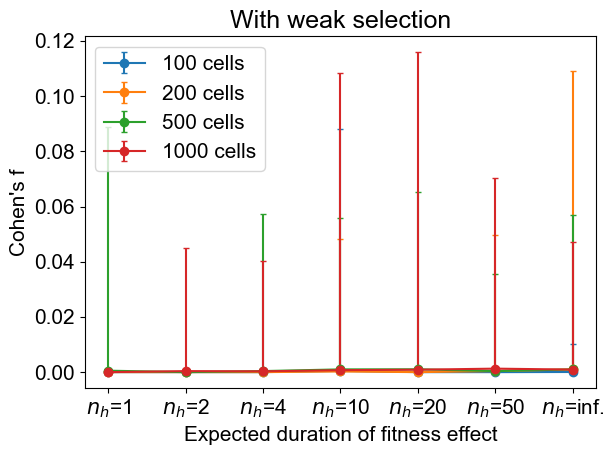

<Figure size 640x480 with 0 Axes>

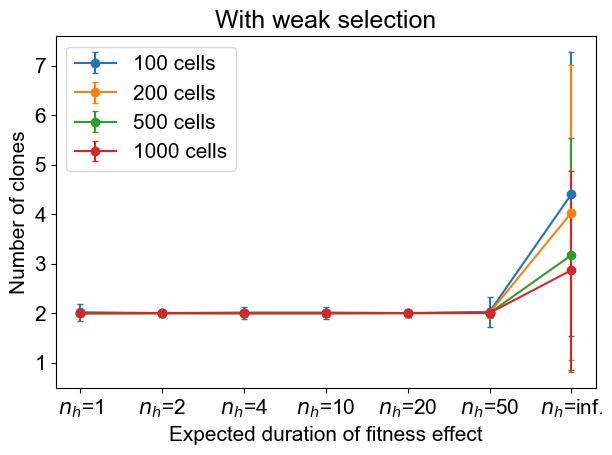

<Figure size 640x480 with 0 Axes>

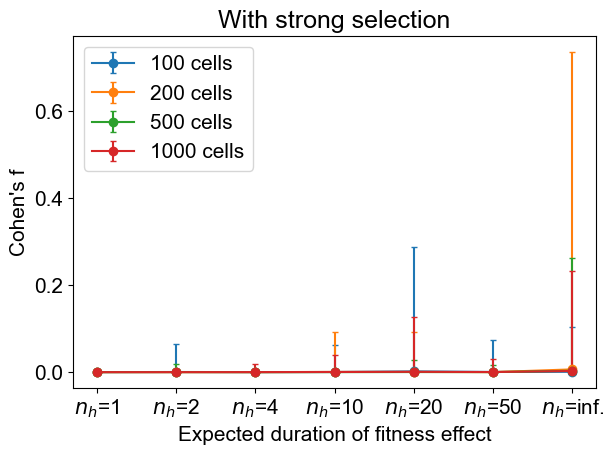

<Figure size 640x480 with 0 Axes>

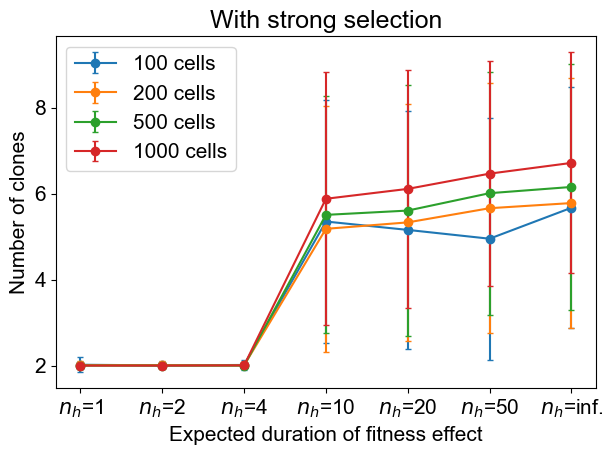

<Figure size 640x480 with 0 Axes>

In [23]:
from matplotlib import pyplot as plt
plast_labels=["$n_h$"+"=1", "$n_h$"+"=2", "$n_h$"+"=4", "$n_h$"+"=10", "$n_h$"+"=20","$n_h$"+"=50", "$n_h$"+"=inf."]

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(herits)), y=av_eff_sizes_low[:, n],  yerr=[min_eff_sizes_low[:, n], max_eff_sizes_low[:, n]], fmt='o', linestyle='-', label=str(no_cells_to_take)+" cells", capsize=2)
#ax.set_xlabel("Heritability of fitness")
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Cohen's f")
plt.title("With weak selection")
plt.legend()
plt.tight_layout()
fig.savefig(save_filepath+"/lowsel_fit_"+tag+".png", dpi=300)
plt.show()
plt.clf()

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(plast_labels)), y=av_num_clones_low[:, n],  yerr=std_num_clones_low[:, n], fmt='o', linestyle='-', label=str(no_cells_to_take)+" cells", capsize=2)
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Number of clones")
plt.title("With weak selection")
plt.legend()
plt.tight_layout()
fig.savefig(save_filepath+"/lowsel_clone_num_"+tag+".png", dpi=300)
plt.show()
plt.clf()

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(herits)), y=av_eff_sizes_high[:, n],  yerr=[min_eff_sizes_high[:, n], max_eff_sizes_high[:, n]], fmt='o', linestyle='-',  label=str(no_cells_to_take)+" cells", capsize=2)
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Cohen's f")
plt.title("With strong selection")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(save_filepath+"/highsel_fit_"+tag+".png", dpi=300)
plt.clf()

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(herits)), y=av_num_clones_high[:, n],  yerr=std_num_clones_high[:, n], fmt='o', linestyle='-', label=str(no_cells_to_take)+" cells", capsize=2)
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Number of clones")
#plt.yticks(range(0, 19, 2), labels=range(0, 19, 2))
plt.legend()
plt.title("With strong selection")
plt.tight_layout()
plt.show()
fig.savefig(save_filepath+"/highsel_clone_num_"+tag+".png", dpi=300)
plt.clf()

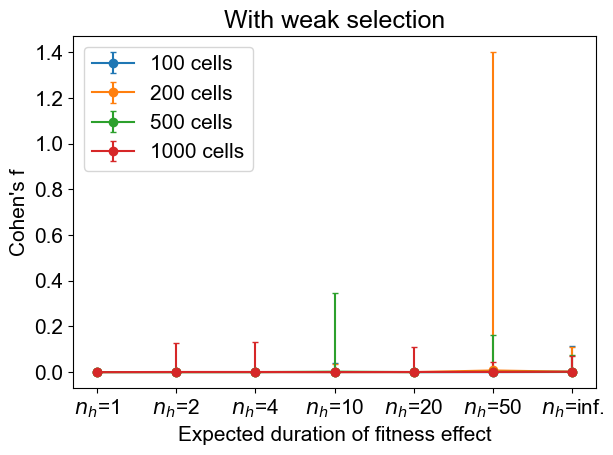

<Figure size 640x480 with 0 Axes>

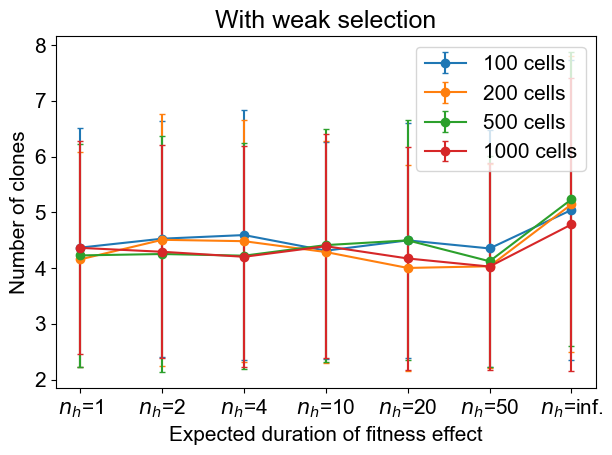

<Figure size 640x480 with 0 Axes>

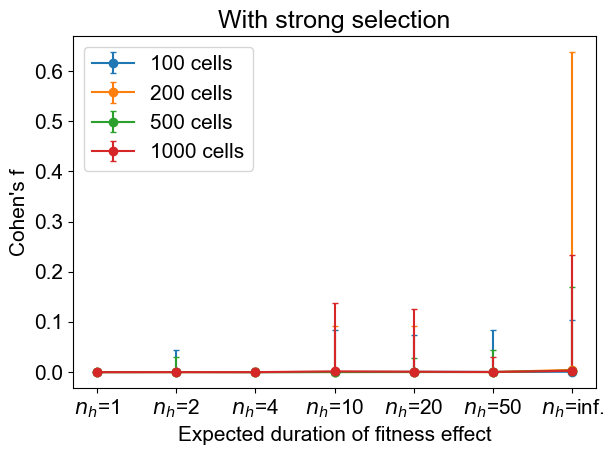

<Figure size 640x480 with 0 Axes>

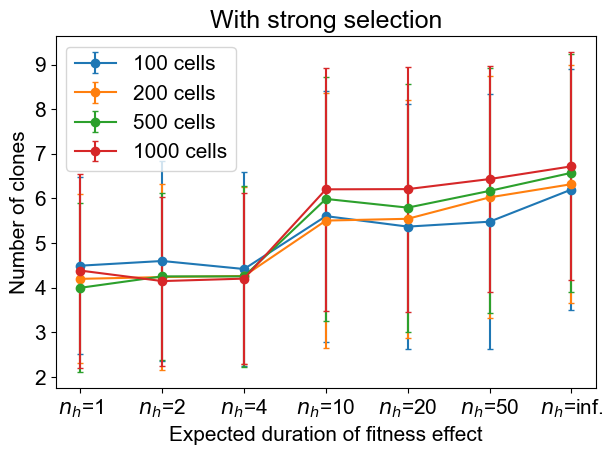

<Figure size 640x480 with 0 Axes>

In [25]:
av_eff_sizes_low, min_eff_sizes_low, max_eff_sizes_low, av_num_clones_low, std_num_clones_low = assemble_cohens(herits, "lowsel", tag="")
av_eff_sizes_high, min_eff_sizes_high, max_eff_sizes_high, av_num_clones_high, std_num_clones_high = assemble_cohens(herits, "highsel", tag="")



tag="abs"

from matplotlib import pyplot as plt
plast_labels=["$n_h$"+"=1", "$n_h$"+"=2", "$n_h$"+"=4", "$n_h$"+"=10", "$n_h$"+"=20","$n_h$"+"=50", "$n_h$"+"=inf."]

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(herits)), y=av_eff_sizes_low[:, n],  yerr=[min_eff_sizes_low[:, n], max_eff_sizes_low[:, n]], fmt='o', linestyle='-', label=str(no_cells_to_take)+" cells", capsize=2)
#ax.set_xlabel("Heritability of fitness")
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Cohen's f")
plt.title("With weak selection")
plt.legend()
plt.tight_layout()
fig.savefig(save_filepath+"/lowsel_fit_"+tag+".png", dpi=300)
plt.show()
plt.clf()

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(plast_labels)), y=av_num_clones_low[:, n],  yerr=std_num_clones_low[:, n], linestyle='-', fmt='o', label=str(no_cells_to_take)+" cells", capsize=2)
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Number of clones")
plt.title("With weak selection")
plt.legend()
plt.tight_layout()
fig.savefig(save_filepath+"/lowsel_clone_num_"+tag+".png", dpi=300)
plt.show()
plt.clf()

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(herits)), y=av_eff_sizes_high[:, n],  yerr=[min_eff_sizes_high[:, n], max_eff_sizes_high[:, n]], fmt='o', linestyle='-',  label=str(no_cells_to_take)+" cells", capsize=2)
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Cohen's f")
plt.title("With strong selection")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(save_filepath+"/highsel_fit_"+tag+".png", dpi=300)
plt.clf()

fig, ax = plt.subplots()
for n, no_cells_to_take in enumerate([100, 200, 500, 1000]):
    ax.errorbar(x=range(len(herits)), y=av_num_clones_high[:, n],  yerr=std_num_clones_high[:, n], fmt='o', linestyle='-', label=str(no_cells_to_take)+" cells", capsize=2)
plt.xlabel("Expected duration of fitness effect", fontsize=15)
ax.set_xticks(range(len(plast_labels)), labels=plast_labels)
plt.ylabel("Number of clones")
plt.legend()
plt.title("With strong selection")
plt.tight_layout()
plt.show()
fig.savefig(save_filepath+"/highsel_clone_num_"+tag+".png", dpi=300)
plt.clf()

Okay, so none of the results change significantly when using absolute vs fractional relatedness. Good to check!

In [ ]:
Using fractional distance will get you fewer clones, but the threshold decreases.

In [ ]:
for i in range(5):
    try:
        assert(1==0)
    except:
        print(i)